!["Facultad de Ingeniería de la UBA"](logoFIUBA.jpg)


### Carrera de Maestría en Inteligencia Artificial (UBA) - _Cohorte 2_
## Análisis de Series Temporales I _(AST1)_
# **Trabajo Práctico 2:** _Linear Predictive Coding_

- #### Autor: Alejandro Lloveras _(a1716)_
- #### Docentes: 
    - Matias Vera
    - Camilo Argoty

---
## ETL

### Ejercicio 1
Utilizando `load` (librosa), cargar el archivo de audio `estocastico.wav` y escucharlo utilizando `Audio` (IPython.display).

In [30]:
import librosa
import IPython.display

x, fs = librosa.load("estocastico.wav")
IPython.display.Audio(x, rate=fs)

### Ejercicio 2
Determinar aproximadamente los instantes de tiempo donde se pronuncian las vocales en el audio `estocastico.wav`. La función `recortar` de `recorte.py` puede ser útil.

In [31]:
from recorte import recortar
markers = recortar(x,fs)

FloatSlider(value=5000.0, description='Inicio:', max=39100.0, min=5000.0, step=100.0)

FloatSlider(value=6000.0, description='Fin:', max=39100.0, min=5000.0, step=100.0)

Button(description='Reproducir segmento', style=ButtonStyle())

Button(description='Agregar marcador', style=ButtonStyle())

Output()

Marcadores guardados (muestras):
1. **Vocal "E":** 13800 - 19700
2. **Vocal "O":** 19700 - 22500
3. **Vocal "A":** 22500 - 28000
4. **Vocal "I":** 28000 - 32000
5. **Vocal "O":** 32000 - 36000

In [32]:
markers = [
    {"start": 13800, "end": 19700, "label": "E"},
    {"start": 19700, "end": 22500, "label": "O"},
    {"start": 22500, "end": 28000, "label": "A"},
    {"start": 28000, "end": 32000, "label": "I"},
    {"start": 32000, "end": 36000, "label": "O"},
]

In [33]:
for i, marker in enumerate(markers):
    print(f"{i+1}º Vocal: {marker['label']}")
    sample = x[marker['start']:marker['end']] # Trim sample
    display(IPython.display.Audio(sample, rate=fs))

1º Vocal: E


2º Vocal: O


3º Vocal: A


4º Vocal: I


5º Vocal: O


---
## Linear Predictive Coding (LPC)

### Ejercicio 3
Utilizando `correlate` (numpy) implementar una función que calcule los coeficientes LPC de una señal (representativa de un solo sonido) para N > M.

In [34]:
import numpy as np
def calc_lpc(y, m):
  """
  Calcula los M coeficientes LPC (h_k) para un segmento de señal y_segmento.
  Se utiliza el método de autocorrelación para resolver el sistema R * h = r.

  Args:
      y_segmento (np.ndarray): El segmento de señal (e.g., una vocal).
      M (int): El orden del modelo LPC (número de coeficientes a estimar).

  Returns:
      h (np.ndarray): Los M coeficientes LPC.
  """
  n = len(y)

  # Comprobación de condición N > M
  if n <= m:
      raise ValueError("La longitud de la señal (N) debe ser mayor que el orden LPC (M) para este método. CONDICIÓN: N > M")

  # Calculo de Autocorrelación Cruzada
  autocorr = np.correlate(y, y, mode='full') # longitud 2*n - 1
  autocorr = autocorr[n-1:]  # almacena lags positivos (k >= 0)
  estimador = autocorr / n  # estimador sesgado
  estimador = estimador[:m+1]  # nos quedamos con los primeros M+1 valores
  
  # Construcción de la matriz R y el vector r
  R = np.array([[estimador[abs(i - j)] for j in range(m)] for i in range(m)])  # matriz simétrica de autocorrelación
  r = estimador[1:]  # vector de autocorrelaciones para lags 1
  h = np.linalg.solve(R, r) # coeficientes LPC: h = R^(-1) * r.
  return h

In [35]:
#TESTEO DE LA FUNCIÓN
max_len = 10 # Longitud máxima de la señal de prueba
test_signal = np.random.randint(-1e2, 1e2, size=np.random.randint(2, max_len)) # Señal aleatoria de prueba
print(f"Señal de prueba (N={len(test_signal)}):\n{test_signal}\n")
print("Estimadores LPC:\n",calc_lpc(test_signal, len(test_signal)-1)) # Debe devolver un array de N coeficientes

Señal de prueba (N=7):
[ -6 -41 -86 -59 -78 -61   0]

Estimadores LPC:
 [ 1.03255856 -0.2400835   0.31277749 -0.61717917  0.24060317  0.06140187]


### Ejercicio 4
Asumiendo conocidos los coeficientes LPC, hallar analíticamente la respuesta impulsiva de un sistema LTI cuya entrada sea $y[t]$ y su salida $x̂[t]$. Es decir, hallar $h_f[t]$ tal que $x̂[t] = (y * h_f)[t]$.

#### 1. Error de Predicción
El error de predicción $x̂[t]$ se define como la diferencia entre la señal actual $y[t]$ y la predicción lineal $\tilde{y}[t]$:

$$\hat{x}[t] = y[t] - \tilde{y}[t]$$

Donde la predicción lineal $y~[t]$ para M muestras anteriores será:

$$\tilde{y}[t] = \sum_{k=1}^{M} h_{k}y[t-k]$$

Sustituyendo $y~[t]$ en la ecuación del error, obtenemos así la ecuación del filtro:

$$\hat{x}[t] = y[t] - \sum_{k=1}^{M} h_{k}y[t-k]$$

#### 2. Forma de Convolución
Según la definición de un sistema LTI, a fórmula de la convolución es:

$$\hat{x}[t] = \sum_{k=-\infty}^{\infty} y[t-k]h_{f}[k]$$
Para encontrar la respuesta impulsiva $h_f[t]$, debemos comparar la ecuación de error con la de la convolución discreta $x[t]=(y∗h_f)[t]$.

Si reescribimos la ecuación del error $x[t]$ en forma de suma:

$$\hat{x}[t] = y[t] - \sum_{k=1}^{M} h_{k}y[t-k]$$

$$\hat{x}[t] = y[t] - (h_{1} y[t-1] + h_{2} y[t-2] + \dots + h_{M} y[t-M])$$

Luego, podemos reagrupar los términos para que sean sumas de la forma $y[t−k]·h_{k}$ donde $h_{k}$ es una constante:

$$\hat{x}[t] = \underbrace{y[t-0] \cdot (1)}_{\text{cuando } k=0} + \underbrace{y[t-1] \cdot (-h_{1})}_{\text{cuando } k=1} + \underbrace{y[t-2] \cdot (-h_{2})}_{\text{cuando } k=2} + \dots + \underbrace{y[t-M] \cdot (-h_{M})}_{\text{cuando } k=M}$$

Para identificar la respuesta impulsiva $h_{f}[k]$, comparamos cada término de la ecuación del error con la definición de la convolución discreta:

| Término ($\sum y[t-k] \cdot \mathbf{Coef}$) | Retardo ($k$) | Coeficiente $h_{f}[k]$ |
| :--- | :---: | :--- |
| $y[t-0] \cdot (1)$ | $k=0$ | $h_{f}[0]=1$ |
| $y[t-1] \cdot (-h_{1})$ | $k=1$ | $h_{f}[1]=-h_{1}$ |
| $y[t-2] \cdot (-h_{2})$ | $k=2$ | $h_{f}[2]=-h_{2}$ |
| $\dots$ | $\dots$ | $\dots$ |
| $y[t-M] \cdot (-h_{M})$ | $k=M$ | $h_{f}[M]=-h_{M}$ |
| $y[t-k]$ para $k>M$ o $k<0$ | $k \ne 0 \text{ a } M$ | $h_{f}[k]=0$ |

#### 3. Respuesta Impulsiva Finita (FIR filter) 

Entonces, la respuesta impulsiva $h_f[t]$ de M+1 coeficientes quedará expresada en forma discreta como:

$$
h_{f}[t] = \begin{cases}
1 & \text{para } t=0 \\
-h_{k} & \text{para } t=k, \text{ con } 1 \le k \le M \\
0 & \text{en todos los demás instantes } t
\end{cases}
$$

**Conclusión:** La respuesta impulsiva del Filtro Predictor es $\mathbf{h_{f}} = [1, -h_{1}, -h_{2}, \dots, -h_{M}]$.


Finalmente, la respuesta impulsiva del filtro predictor en términos del Impulso Discreto (δ[t]) es:

$$h_{f}[t] = \delta[t] - \sum_{k=1}^{M} h_{k}\delta[t-k]$$

### Ejercicio 5
Utilizando `convolve` (numpy) implementar una función que estime la frecuencia de excitación a partir de la señal de un sonido y sus coeficientes LPC.

La fórmula de la convolución que estime la señal de excitación será:
$$\hat{x}[t]=(y \ast h_{f})[t]$$

In [36]:
import numpy as np

def impulse_h(h):
    """
    Obtiene la respuesta impulsiva (coeficientes FIR) del filtro predictor.
    """
    return np.concatenate(([1], -np.array(h))) # h_f[0] = 1, h_f[m] = -h[m-1] para m=1...M

def cacl_pred_error(y, h):
    """
    Estima la señal de excitación (error de predicción) a partir del segmento de habla
    y los coeficientes LPC.
    
    Args:
        y (np.ndarray): El segmento de señal de habla, y[t].
        h (np.ndarray): Los M coeficientes LPC, h.
        
    Returns:
        np.ndarray: La señal de excitación estimada, x_hat[t].
    """

    # Construye la respuesta impulsiva del filtro inverso/predictor
    h_f = impulse_h(h)  # [1, -h1, -h2, -h3]

    # Calcula el error de predicción
    # Convolución: x_hat[t] = y[t] * h_f[t]
    x_hat = np.convolve(y, h_f, mode='full')  # 'full' da la señal completa
    
    return x_hat[:len(y)] # Recorta a la longitud original

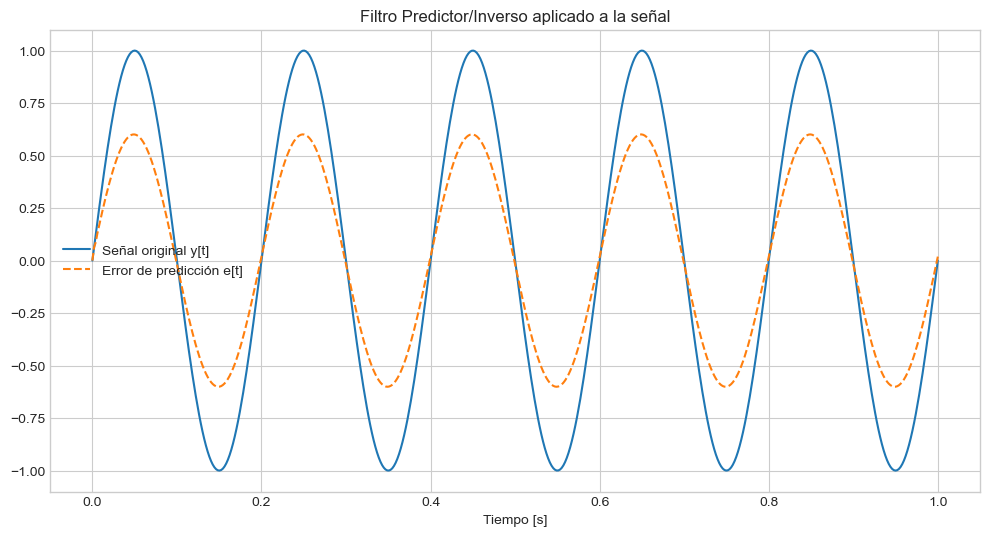

In [37]:
# TESTEO DE LA FUNCIÓN
import matplotlib.pyplot as plt

# Señal de entrada (puede ser señal de habla o cualquier señal de prueba)
t = np.linspace(0, 1, 500) # línea de tiempo
test_signal = np.sin(2 * np.pi * 5 * t)  # señal de prueba: seno de 5 Hz
h = np.array([0.6, -0.3, 0.1])  # Coeficientes del modelo LPC: h1, h2, h3

e = cacl_pred_error(test_signal, h)

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(t, test_signal, label='Señal original y[t]')
plt.plot(t, e, label='Error de predicción e[t]', linestyle='--')
plt.title('Filtro Predictor/Inverso aplicado a la señal')
plt.xlabel('Tiempo [s]')
plt.legend()
plt.grid(True)
plt.show()

### Ejercicio 6
Asumiendo conocidos los coeficientes LPC, hallar una solución analítica para $H_f(e^{jω})$ _(la respuesta en frecuencia del filtro del Ej. 4)._

#### 1. Transformada de Fourier de Tiempo Discreto (DTFT)

Por lo concluido en el Ejercicio 4, la respuesta impulsiva del Filtro Predictor es:

$$h_{f}[t] = \delta[t] - \sum_{k=1}^{M} h_{k}\delta[t-k]$$

donde $M$ es el orden del predictor y $h_{k}$ son los coeficientes LPC conocidos.

La respuesta en frecuencia $H_{f}(e^{j\omega})$ se define como la **Transformada de Fourier de Tiempo Discreto (DTFT)** de $h_{f}[t]$:

 $$H_{f}(e^{j\omega})=\sum_{t=-\infty}^{\infty}h_{f}[t]e^{-j\omega t}$$

Si reemplazamos $h_{f}[t]$ por la respuesta impulsiva calculada:

$$
H_f(e^{j\omega}) = \sum_{t=-\infty}^{\infty} \left(\delta[t] - \sum_{k=1}^{M} h_k \delta[t - k] \right) e^{-j\omega t}
$$

#### 2. Solución Analítica para $H_{f}(e^{j\omega})$

Podemos separar la sum en dos partes gracias a la propiedad de linealidad de la transformada:

$$
H_f(e^{j\omega}) = 
% Primer término
\sum_{t=-\infty}^{\infty} \delta[t] e^{-j\omega t}
% Segundo término
- \sum_{t=-\infty}^{\infty}  \left(\sum_{k=1}^{M} h_k \delta[t - k] \right) e^{-j\omega t}
$$

##### a. Primer término: *impulso discreto $\delta[t]$*
Como sabemos, el impulso discreto $\delta[t]$ sólo es distinto de cero cuando $t=0$:

$$\delta[n] = \begin{cases} 1 & \text{si } n=0 \\ 0 & \text{si } n\neq 0 \end{cases}$$

Entonces:
$$
\sum_{t=-\infty}^{\infty} \delta[t] e^{-j\omega t} = \delta[0] e^{-j\omega 0} = 1 · 1 = 1
$$

##### b. Segundo término: retardos

Al ser $\sum_{k=1}^{M}$ una suma finita de términos, podemos aplicar propiedad conmutativa a las sums _(por Teorema de Fubini)_:

$$ - \sum_{k=1}^{M} h_{k} \left( \sum_{t=-\infty}^{\infty} \delta[t-k] e^{-j\omega t} \right)$$

Por propiedad del impulso discreto, la sum será 0 para todo $t\neq k$. Entonces, al evaluar la sum en $t=k$:
$$ - \sum_{k=1}^{M} h_{k} \left( e^{-j\omega k} \right)$$

##### c. Conclusión

Combinando ambos resultados, la respuesta en frecuencia del Filtro Predictor será:

$$H_{f}(e^{j\omega})=1-\sum_{k=1}^{M}h_{k}e^{-j\omega k}$$

### Ejercicio 7
Asumiendo conocidos los coeficientes LPC, hallar una solución analítica para $H_i(e^{jω})$ _(la respuesta en frecuencia del filtro definido en (5), donde $x̂[t]$ es la entrada y $ŷ[t]$ la salida)._

La reconstrucción $\hat{y}[t]$ de la señal se define como:
$$\hat{y}[t] = \hat{x}[t] + \sum_{m=1}^{M} h_{m} \hat{y}[t - m]$$

####  1. Transformada $Z$

Para encontrar la función de transferencia $H_i(z) = \frac{\hat{X}(z)}{\hat{Y}(z)}$, aplicamos la Transformada $Z$ a la
ecuación de diferencias.

$$ \mathcal{Z}\{\hat{y}[t]\} = \mathcal{Z}\{\hat{x}[t]\} + \mathcal{Z} \left\{ \sum_{k=1}^{M} h_{k} \hat{y}[t - k] \right\} $$

Por propiedad aditiva es posible aplicar la transformada $Z$ directamente a cada término de la suma $ \mathcal{Z}\left\{ \sum_{k=1}^{M} h_{k} \hat{y}[t-k] \right\} = \sum_{k=1}^{M} \mathcal{Z}\left\{ h_{k} \hat{y}[t-k] \right\} $.

Luego, podemos sacar la constante fuera por propiedad de linealidad:

$$ \mathcal{Z}\{\hat{y}[t]\} = \mathcal{Z}\{\hat{x}[t]\} +  \sum_{k=1}^{M} h_{k} \mathcal{Z}\left\{ \hat{y}[t - k]  \right\} $$


Además, usando la propiedad del retardo $\mathcal{Z}\{\hat{y}[t - k]\} = \hat{Y}(z)z^{-k}$:

$$\hat{Y}(z) = \hat{X}(z) + \sum_{k=1}^{M} h_{k} \hat{Y}(z) z^{-k}$$

#### 2. Función de Transferencia $H_i(z)$
Agrupamos $\hat{Y}(z)$ a un lado de la ecuación:
$$ \hat{Y}(z) - \sum_{k=1}^{M} h_{k} \hat{Y}(z) z^{-k} = \hat{X}(z) $$

Factorizando $\hat{Y}(z)$:
$$ \hat{Y}(z) \left( 1 - \sum_{k=1}^{M} h_{k} z^{-k} \right) = \hat{X}(z) $$

Como se definió antes, la relación $\frac{\hat{X}(z)}{\hat{Y}(z)}$ es la función de transferencia $H_i(z)$:
$$ H_i(z) = \frac{\hat{X}(z)}{\hat{Y}(z)} = \frac{1}{1-\sum_{k=1}^{M} h_{k} z^{-k}}$$

#### 3. Solución Analítica Final $H_i(e^{j\omega})$
Si evaluamos la Transformada $Z$ en el círculo unitario,
sustituyendo por $z = e^{j\omega}$:

$$H_i(e^{j\omega}) = \frac{1}{1 - \sum_{k=1}^{M} h_{k} e^{-j\omega k}}$$

### Ejercicio 8
Implementar una función que represente el sistema descripto en (5) _(entrada $x̂[t]$ y salida $ŷ[t]$)_ a partir de su ecuación en diferencias.

**Nota:** No trate encontrar la respuesta impulsiva $h_i[t]$ definida en el Ej. 7 porque la misma posee duración infinita.

In [38]:
def rebuild_y(x_hat, h):
    """
    Reconstruye la señal de habla y_hat[t] a partir de la excitación x_hat[t] 
    y los coeficientes LPC h, usando la ecuación en diferencias.
    
    Ecuación: y_hat[t] = x_hat[t] + sum(h_m * y_hat[t-m])
    
    Args:
        x_hat (np.ndarray): La señal de excitación estimada.
        h (np.ndarray): Los M coeficientes LPC, h.
        
    Returns:
        np.ndarray: La señal de habla reconstruida, y_hat[t].
    """
    N = len(x_hat)
    M = len(h)
    y_hat = np.zeros(N)
    
    # Se asumen M valores anteriores a y_hat[0] son cero.
    memory = np.zeros(M)
    
    # Iteración sobre la señal de excitación
    for t in range(N):
        sum = 0.0
        for m in range(1, M + 1):
            # h_m es h[m-1], y_hat[t-m] es memory[m-1]
            sum += h[m-1] * memory[m-1]
            
        # Ecuación en diferencias
        y_hat[t] = x_hat[t] + sum
        
        # Actualizamos la memoria: deslizar y añadir el nuevo valor
        memory = np.roll(memory, -1) # Se desplaza a la izquierda
        memory[M-1] = y_hat[t] # Se agrega el nuevo valor al final (posición t-1)
        
    return y_hat

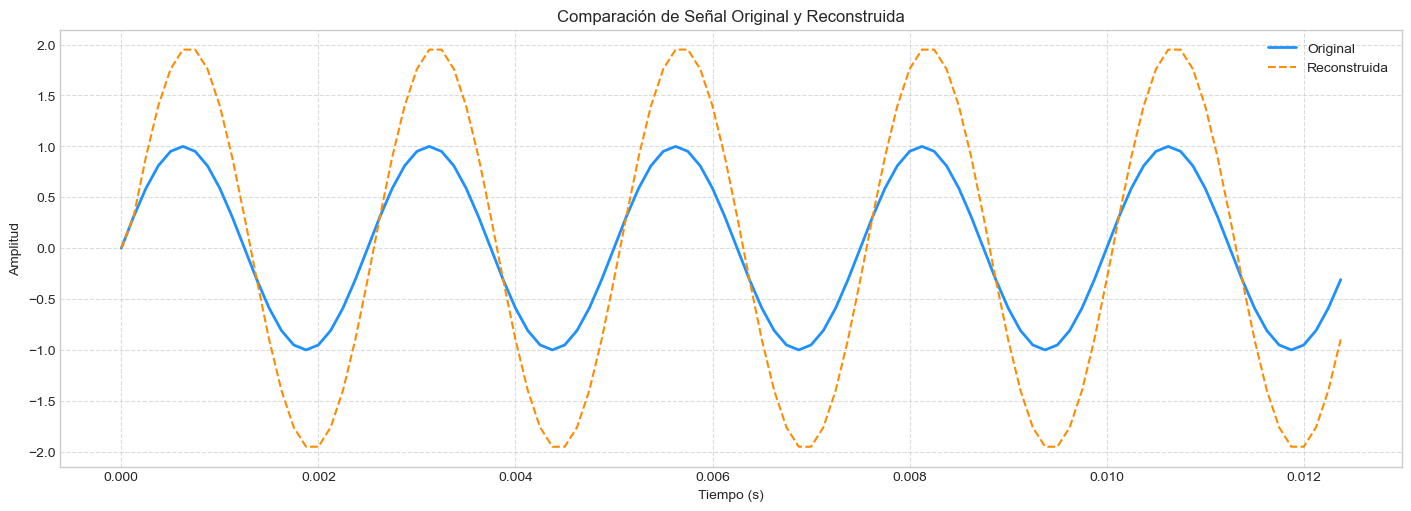

In [39]:
#TESTEO DE LA FUNCIÓN
sr = 8000  # Frecuencia de muestreo
duration = 1  # segundos
f0 = 400  # Frecuencia (Hz)
time = np.linspace(0., duration, int(sr * duration), endpoint=False)

# Señal de entrada (puede ser señal de habla o cualquier señal de prueba)
test_signal = np.sin(2 * np.pi * f0 * time)
test_signal /= np.max(np.abs(test_signal)) # Normalizar

# Cálculo de Coeficientes LPC
orden_lpc = 100 
window = test_signal # Analizar toda la señal

a = calc_lpc(window, orden_lpc)
coef = a[1:] # Coeficientes LPC (h1, h2, ...)
e = cacl_pred_error(test_signal, coef) # Estimación de la Excitación
y_rebuilt = rebuild_y(e, coef) # Reconstrucción de la señal

# Graficar resultados
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(14, 5), constrained_layout=True)

range_time = int(sr / f0 * 5) # Definir el rango de tiempo

ax.plot(time[:range_time], test_signal[:range_time], color='dodgerblue', label='Original', linewidth=2)
ax.plot(time[:range_time], y_rebuilt[:range_time], color='darkorange', label='Reconstruida', linestyle='--')
ax.set_title(f"Comparación de Señal Original y Reconstruida")
ax.set_ylabel("Amplitud")
ax.set_xlabel("Tiempo (s)") # Añadimos la etiqueta del eje X aquí
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

plt.show()

---
## Ventaneo _(Windowing)_

***TIPS:***
- El uso estándar es considerar ventanas de señal de longitud **0,025 seg**, actualizadas cada **0,010 seg** para calcular los coeficientes LPC.
- Es recomendable utilizar la ventana de Hamming que ***reduzca la inclusión de altas frecuencias*** debido al proceso de ventaneo.
- Se considera que para la mayor parte de las secciones de la señal de habla, **20 coeficientes** es suficiente.

In [40]:
# Parámetros estimados
window_len = 0.025 * fs # Longitud de la ventana (en muestras)
hop = 0.01 * fs  # Desplazamiento entre ventanas (en muestras)
M = 20 # Orden del modelo LPC (número de coeficientes h_k)
print(f'Parámetros sugeridos dado un sample rate (fs) de {fs/1000:.1f} kHz:')
print(f"- Longitud de ventana: {window_len} muestras")
print(f"- Desplazamiento: {hop} muestras")
print(f"- Orden del modelo LPC: {M} (señal de habla)")

Parámetros sugeridos dado un sample rate (fs) de 22.1 kHz:
- Longitud de ventana: 551.25 muestras
- Desplazamiento: 220.5 muestras
- Orden del modelo LPC: 20 (señal de habla)


### Ejercicio 9
Utilizando la función desarrollada en el Ej. 3, calcular los coeficientes LPC del audio `estocastico.wav` para cada ventana de tiempo de la señal. Utilizar la ventana de `hamming` (numpy).

In [41]:
# Parámetros definidos
window_len = 500 # Longitud de la ventana (en muestras)
hop = 200 # Desplazamiento entre ventanas (en muestras)
M = 20 # Orden del modelo LPC (número de coeficientes h_k)

# Construye la ventana de Hamming
hamming_win = np.hamming(window_len)

coef = [] # Inicializa lista para coef LPC
n_samples = len(x) # Audio cargado previamente
index = 0

# Itera sobre la señal
while index + window_len <= n_samples:
    segment = x[index:index + window_len] # Recorte de la señal
    segment_win = segment * hamming_win # Se aplica la ventana de Hamming
    h_k = calc_lpc(segment_win, M) # Cálculo de coeficientes LPC
    coef.append(h_k)
    index += hop

# Convertir a array de numpy
print(f"✅ Cálculo LPC compeltado:")
print(f"- Número total de ventanas: {len(np.array(coef))}")
print(f"- Dimensiones de cada array LPC: {np.array(coef).shape} (Nº ventanas x M)")

✅ Cálculo LPC compeltado:
- Número total de ventanas: 219
- Dimensiones de cada array LPC: (219, 20) (Nº ventanas x M)


### Ejercicio 10
Utilizando `specgram` (matplotlib) graficar un espectrograma del audio `estocastico.wav`, configurando sus parámetros según lo discutido previamente.

In [42]:
def show_spectrogram(signal, fs, window_len, hop):
    """
    Muestra el espectrograma de la señal con los parámetros dados.
    
    Args:
        signal (np.ndarray): La señal de audio.
        fs (int): La frecuencia de muestreo.
        window_len (int): La longitud de la ventana (en muestras).
        hop (int): El desplazamiento entre ventanas (en muestras).
    """
    hamming_win = np.hamming(window_len) # Ventana de Hamming
    noverlap = window_len - hop # Número de muestras solapadas (Longitud - hop)

    plt.figure(figsize=(12, 6))
    plt.specgram(signal, # Señal de habla original
                NFFT=window_len, 
                Fs=fs, 
                noverlap=noverlap, 
                window=hamming_win,
                cmap='viridis')

    plt.title(f'Espectrograma de Audio\n(Ventana: {window_len/fs*1000:.1f}ms, hop: {hop/fs*1000:.1f}ms)')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Frecuencia (Hz)')
    plt.colorbar(label='Magnitud (dB)')
    plt.ylim(0, fs/2) # hasta la frecuencia de Nyquist
    plt.grid(False) 
    plt.show()

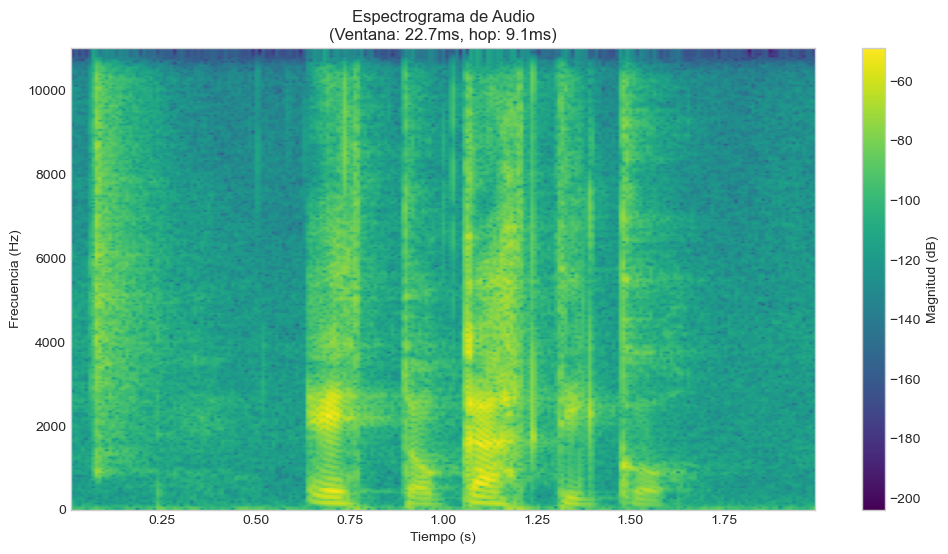

In [43]:
show_spectrogram(x, fs, window_len, hop)

### Ejercicio 11
Elegir los coeficientes LPC correspondientes a una ventana de tiempo de la letra _/e/_. Graficar $|H_f(e^{jω})|$ y $|H_i(e^{jω})|$.

#### 1. Indentificación del a vocal /e/

In [44]:
print("Marcadores de segmentos de interés:")
markers[0]

Marcadores de segmentos de interés:


{'start': 13800, 'end': 19700, 'label': 'E'}

In [45]:
frame_start = markers[0]['start']
frame_end = markers[0]['end']

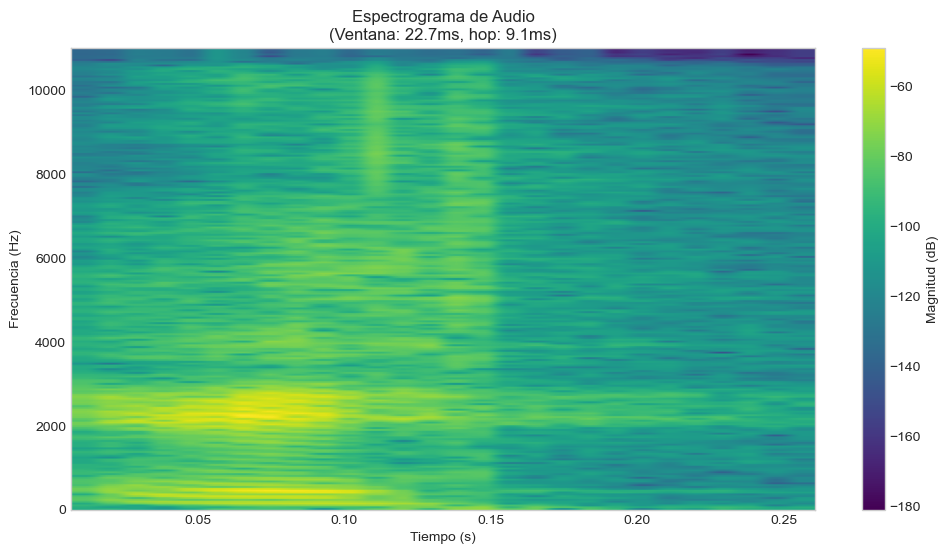

In [46]:
show_spectrogram(x[frame_start:frame_end], fs, window_len, hop)

#### 2. Gráficos de $H_f$ y $H_i$

Filtro del Error de Predicción (LPC):
$$H_f(e^{j\omega}) = 1 - \sum_{m=1}^{M} h_{m} e^{-j\omega m}$$

Filtro de Síntesis:
$$H_i(e^{j\omega}) = \frac{1}{H_f(e^{j\omega})}$$

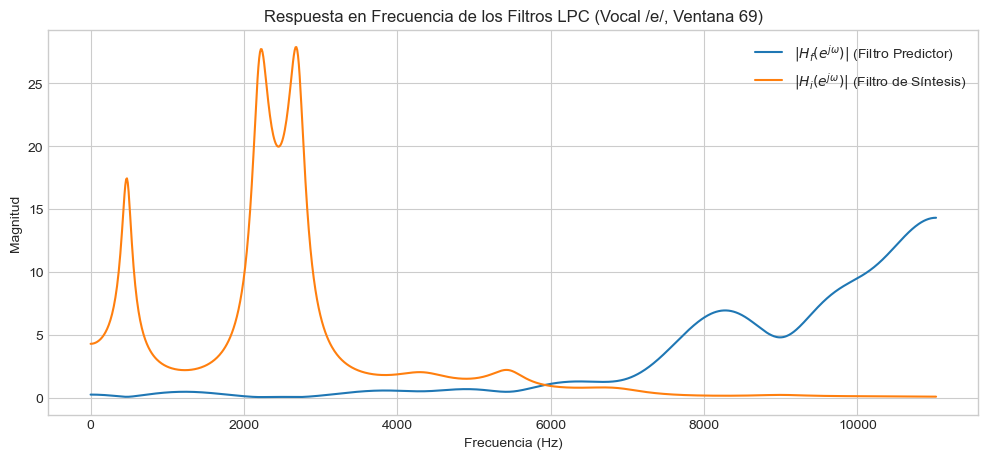

In [47]:
# Se seleccióna la ventana que corresponde a la vocal /e/
index = markers[0]['start'] // hop  # Índice de ventana
h_e = coef[index] # Coeficientes LPC para la vocal /e/
M = len(h_e) # Orden del modelo LPC

# 1. Calculamos Omega (valores de frecuencia)
fft_points = 1024
omega = np.linspace(0, np.pi, fft_points) # Frecuencias normalizadas de 0 a pi
freq = omega * fs / (2 * np.pi)

# 2. Calculamos filtros H_f y H_i
H_f = np.ones(fft_points, dtype=complex)
for m in range(1, M + 1): # el coeficiente h_m es h_e[m-1]
    H_f -= h_e[m-1] * np.exp(-1j * omega * m) # Filtro Predictor (H_f)

H_i = 1.0 / H_f # Filtro de Síntesis (H_i)

# 3. Grafico de resultados
plt.figure(figsize=(12, 5))

plt.plot(freq, np.abs(H_f), # Gráfico de H_f (Filtro Predictor)
         label='$|H_f(e^{j\omega})|$ (Filtro Predictor)')
plt.plot(freq, np.abs(H_i), # Gráfico de H_i (Filtro de Síntesis - Tracto Vocal)
         label='$|H_i(e^{j\omega})|$ (Filtro de Síntesis)')

plt.title(f'Respuesta en Frecuencia de los Filtros LPC (Vocal /e/, Ventana {index})')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.legend()
plt.grid(True)
plt.show()

#### Conclusiones
Este gráfico resume la esencia del **Análisis LPC** al mostrar el modelado del tracto vocal:
- Por un lado, la curva **naranja $|H_i(e^{j\omega})|$** representa el **Filtro de Síntesis**, cuya función es modelar la **envolvente espectral** del habla, revelando claramente las **formantes** (resonancias del tracto vocal) para la vocal /e/ (F1 en $\approx 500 \text{ Hz}$, F2 en $\approx 2300 \text{ Hz}$).
- Por el otro, la curva **azul $|H_f(e^{j\omega})|$** es el **Filtro Predictor**, que opera como el **inverso** exacto del filtro de síntesis; su baja magnitud en las frecuencias de las formantes demuestra que su propósito es **cancelar la energía predecible** del espectro (los polos de $H_i$), dejando solo el error de excitación y confirmando que sus **ceros** se colocan directamente sobre los **polos** del filtro de síntesis.

Lunción primordial del l Filtro Predictor $H_f$ es cancelar el espectro de la señal de voz, para eliminar las componentes predecibles de la señal, dejando solo el error de predicción (idealmente sería un ruido blanco).

### Ejercicio 12
Utilizando la función desarrollada en el Ej. 5, estimar la función de excitación $x̂[t]$ del audio `estocastico.wav` cuidando de evitar los transitorios del filtro. Esto puede hacerse conservando los transitorios finales de cada sección, y sumándolos al siguiente segmento.

$$\hat{x}[n] = \sum_{k=0}^{M} h_f[k] \cdot y[n-k]$$

In [48]:
def estimate_excitation(x, window_len, hop, M, coef):
    """
    Estima la función de excitación x_hat[t] del audio x,
    gestionando los transitorios del filtro entre segmentos.
    """

    # Segmentación de la señal de habla 'x'
    x_frames = librosa.util.frame(x, frame_length=window_len, hop_length=hop, axis=0)

    # Inicialización
    x_hat_total = np.zeros_like(x, dtype=np.float64) # Señal reconstruida
    y_prev = np.zeros(M, dtype=np.float64) # Estado inicial del filtro
    n_samples = len(x) # Definición de índices de ventana

    # Iteramos sobre cada segmento de habla
    for i, y_segment in enumerate(x_frames):
        
        # 1. Coeficientes LPC
        h = coef[i]

        # 2. Concatena la cola del segmento anterior
        y_extended = np.concatenate((y_prev, y_segment))

        # 3. Error de Predicción
        x_hat_segment = cacl_pred_error(y_extended,h)[M:M+window_len]
        
        # 4. Actualiza el estado para la siguiente ventana
        y_prev = y_segment[-M:] # Últimos M valores
        
        # 5. Determina el punto de inicio
        start_idx = i * hop
        end_idx = start_idx + window_len
        
        # 6. Asegura que no supere el límite de x_hat_total
        if end_idx <= n_samples:
                x_hat_total[start_idx:end_idx] += x_hat_segment
        else:
                # Caso borde: El último segmento es más corto
                seg_len = n_samples - start_idx
                x_hat_total[start_idx:n_samples] += x_hat_segment[:seg_len]
            
    # 7. Normalización por superposición (Overlap-Add)
    # Por la superposición de las ventanas necesitamos normalizar la señal reconstruida
    overlap_factor = window_len / hop
    return x_hat_total / overlap_factor

✅ Estimación de excitación completada.



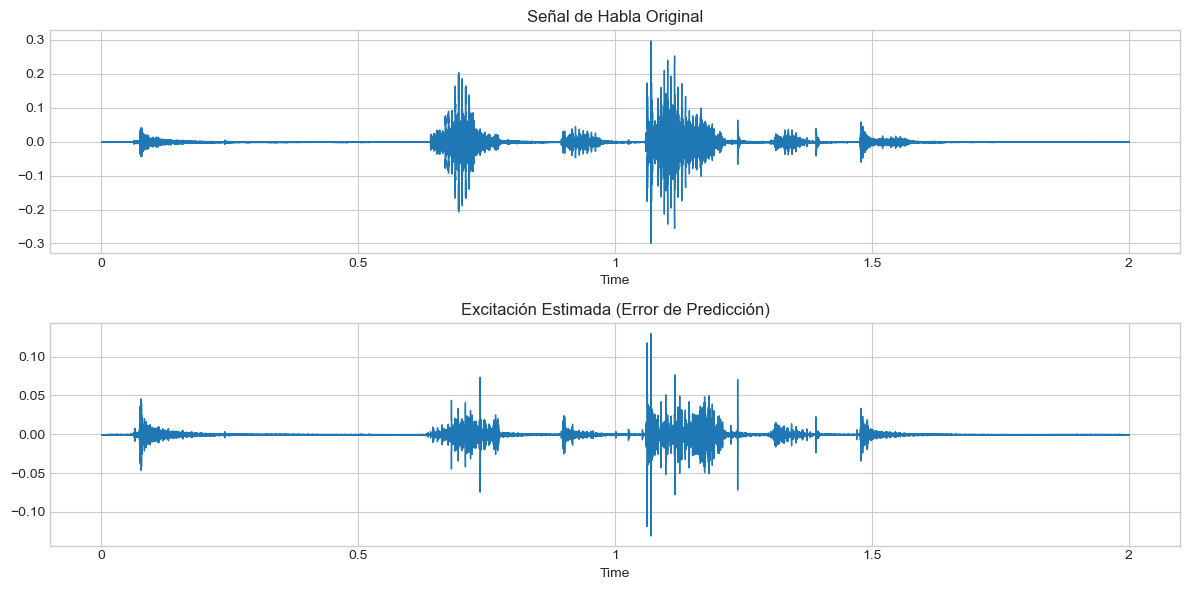

Señal original (x): (44100,)
Excitación estimada (x̂): (44100,)


In [49]:
x_hat = estimate_excitation(x, window_len, hop, M, coef=coef)
print(f"✅ Estimación de excitación completada.\n")

# Visualización de resultados
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
librosa.display.waveshow(x, sr=fs)
plt.title('Señal de Habla Original')
plt.subplot(2, 1, 2)
librosa.display.waveshow(x_hat, sr=fs)
plt.title('Excitación Estimada (Error de Predicción)')
plt.tight_layout()
plt.show()

print(f"Señal original (x): {x.shape}")
print(f"Excitación estimada (x̂): {x_hat.shape}")
IPython.display.Audio(x_hat, rate=fs)

### Ejercicio 13
Utilizando la función desarrollada en el Ej. 8, reconstruir la señal de habla $ŷ[t]$ y escucharla utilizando `Audio` (IPython.display).

In [ ]:
def reconstruct_speech(x_hat, window_len, hop, M, coef):
    """
    Reconstruye la señal de habla y_hat[t] filtrando la excitación x_hat[t] 
    con el filtro de síntesis (IIR) y gestionando los transitorios.
    """
    # Segmentación de la Excitación y de la Señal Original (para LPC)
    x_hat_frames = librosa.util.frame(x_hat, frame_length=window_len, hop_length=hop, axis=0)

    # Inicialización
    y_hat_total = np.zeros_like(x_hat, dtype=np.float64)
    y_prev = np.zeros(M, dtype=np.float64) # Estado para el filtro IIR de síntesis
    n_samples = len(x_hat)
    n_frames = x_hat_frames.shape[0]

    # Iteramos sobre cada segmento de habla
    for i in range(n_frames):
        x_hat_segment = x_hat_frames[i]

        # 1. Coeficientes LPC
        h = coef[i]
        
        # 2. Inicialización del segmento de salida
        y_hat_segment = np.zeros(window_len, dtype=np.float64)
        
        # 3. Implementación de la Ecuación de Diferencias IIR
        # y_hat[n] = x_hat[n] + sum(h_k * y_hat[n-k])
        for n in range(window_len):
            
            # Parte de Realimentación (Memoria)
            sum_feedback = 0.0
            # Itera sobre los M coeficientes LPC
            for k in range(1, M + 1):
                h_k = h[k - 1] # Coeficiente h[k]
                # Accede a la Muestra Anterior y_hat[n-k]
                if n - k >= 0:
                    y_prev_sample = y_hat_segment[n - k] # Muestra dentro del segmento actual
                else:
                    y_prev_sample = y_prev[M + (n - k)] # Muestra del segmento anterior 
                
                sum_feedback += h_k * y_prev_sample
            
            # Filtro de Síntesis (IIR)
            y_hat_segment[n] = x_hat_segment[n] + sum_feedback

        # 4. Actualiza el estado para el siguiente segmento
        y_prev = y_hat_segment[-M:]
        
        # 5. Superposición y Adición (Overlap-Add)
        start_idx = i * hop
        seg_len_to_add = min(window_len, n_samples - start_idx)
        if seg_len_to_add > 0:
            y_hat_total[start_idx:start_idx + seg_len_to_add] += y_hat_segment[:seg_len_to_add]
        
    # 6. Normalización por superposición
    overlap_factor = window_len / hop
    return y_hat_total / overlap_factor

✅ Reconstrucción de señal completada.



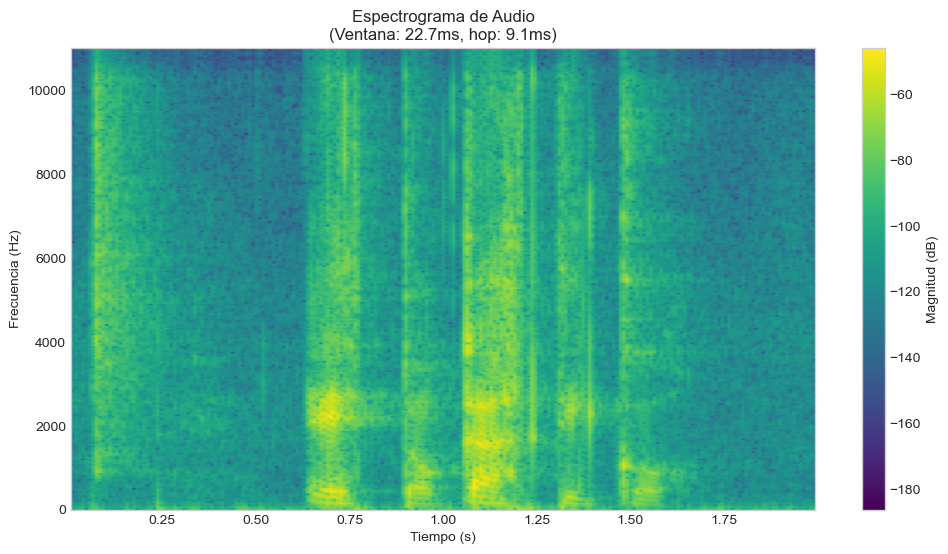

Señal original (x): (44100,)


Señal reconstruida (ŷ): (44100,)


In [51]:
y_hat = reconstruct_speech(x_hat, window_len, hop, M, coef=coef)
print(f"✅ Reconstrucción de señal completada.\n")
show_spectrogram(y_hat, fs, window_len, hop)

print(f"Señal original (x): {x.shape}")
display (IPython.display.Audio(x, rate=fs))
print(f"Señal reconstruida (ŷ): {y_hat.shape}")
display (IPython.display.Audio(y_hat, rate=fs))

---
## Ejercicios Optativos

### Ejercicio 14
Se desea reemplazar todas las vocales del audio con la letra /e/. Para ello, defina unos nuevos coeficientes LPC a partir de los originales. Reemplace todos los coeficientes correspondientes a vocales con los utilizados en el Ej. 11. Reconstruir la señal de habla _(utilizando la señal $x̂[t]$ del Ej. 12)_ y escucharla utilizando `Audio` (IPython.display).

✅ Reconstrucción de señal completada.


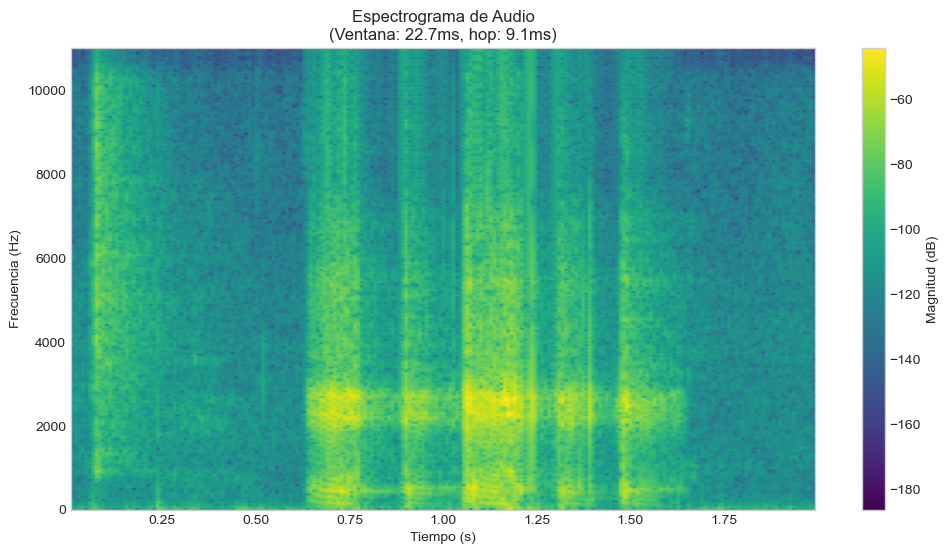

In [52]:
coef_mod = coef.copy() # Copia de los coeficientes para modificar

# Reemplazamos los coeficientes LPC de las ventanas
# correspondientes a los segmentos de vocales por h_e
for marker in markers:
    start_win = marker['start'] // hop
    end_win = marker['end'] // hop
    for i in range(start_win, end_win):
        if i < len(coef_mod):
            coef_mod[i] = h_e # Coeficientes LPC para la vocal /e/ (Ej. 11)

# Reconstruimos la señal de habla con todas las vocales reemplazadas por /e/
y_hat_e = reconstruct_speech(x_hat, window_len, hop, M, coef=coef_mod)

print("✅ Reconstrucción de señal completada.")
show_spectrogram(y_hat_e, fs, window_len, hop)
display(IPython.display.Audio(y_hat_e, rate=fs))

### Ejercicio 15
Se desea cambiar la frecuencia glótica del audio. Para ello se modificará $x̂[t]$ en los segmentos correspondientes a los fonemas sonoros _(vocales en este caso)_.

Cada segmento completo correspondiente a una vocal será duplicado _(concatenando uno a continuación del otro)_ y quedándose con una de cada dos muestras _(duplicando la frecuencia)_. 

Reconstruir la señal de habla _(utilizando los coeficientes LPC del Ej. 9)_ y escucharla utilizando `Audio` (IPython.display).

In [53]:
def double_segment(x_hat, markers):
    """
    Modifica x_hat duplicando la frecuencia en los segmentos de las vocales.
    Cada segmento es duplicado y luego se toma una de cada dos muestras.
    """
    x_hat_new = x_hat.copy() # Copia para modificar
    for marker in markers:
        start, end = marker['start'], marker['end']
        segment = x_hat[start:end]
        segment_concat = np.concatenate([segment, segment]) # Duplica el segmento
        segment_new = segment_concat[::2] # Downsample 2:1 (usa 1 cada 2 muestras)
        x_hat_new[start:end] = segment_new # Reemplaza con la señal modificada
    return x_hat_new

✅ Reconstrucción de señal completada.


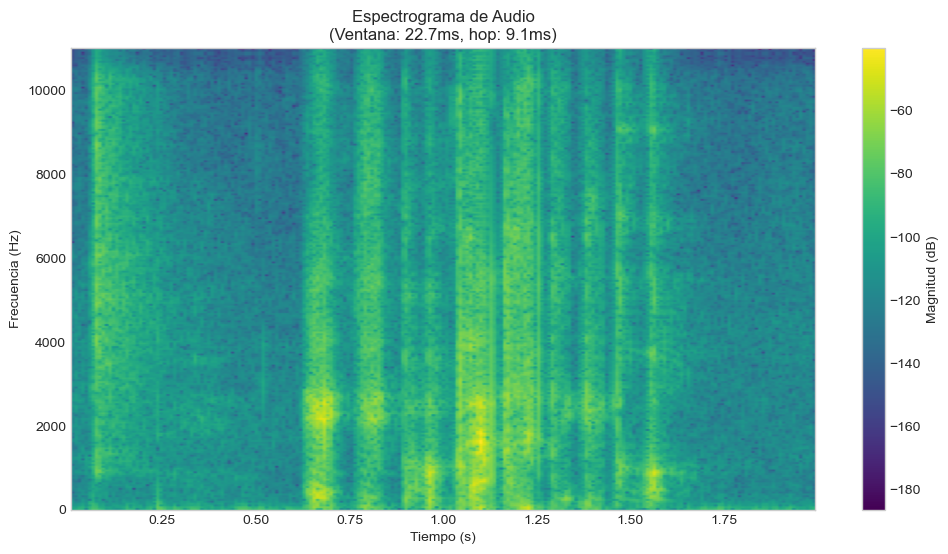

In [ ]:
# Duplicamos la frecuencia glótica en los segmentos de vocales
x_hat_doubled = double_segment(x_hat, markers)

# Reconstruimos la señal de habla con los coeficientes LPC originales (Ej. 9)
y_hat_doubled = reconstruct_speech(x_hat_doubled, window_len, hop, M, coef=coef)

print("✅ Reconstrucción de señal completada.")
show_spectrogram(y_hat_doubled, fs, window_len, hop)
display(IPython.display.Audio(y_hat_doubled, rate=fs))